# Discrete space simulations with `msprime`

Since we've used this package in the earlier workshops, it's worth highlighting that you can do simple stepping stone (discrete space) simulations with `msprime` by altering the `Demography` object. Let's set up a grid of demes, where each deme is set to a constnat population size.

In [ ]:
random_seed = 1234

In [17]:
import msprime
import matplotlib.pyplot as plt
import random

random.seed(random_seed)


grid_height = 10
grid_width = 10
deme_size = 50

demography = msprime.Demography()

ids, xs, ys = [], [], []

for h in range(grid_height):
    for w in range(grid_width):
        id = str((h*grid_height)+w)
        demography.add_population(name="Pop_"+id, initial_size=deme_size)
        ids.append(id)
        xs.append(w)
        ys.append(h)

Normally, you do not need to store the IDs and coordinates of the demes, but this allows us to plot the "world map" (stepping stone metapopulation) with `matplotlib`.

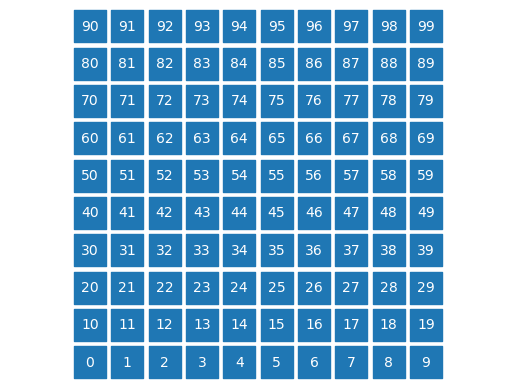

In [18]:
fig, ax = plt.subplots()

ax.scatter(xs, ys, marker="s", s=500)

for i, text in enumerate(ids):
    ax.annotate(text, (xs[i], ys[i]), ha="center", va="center", color="white")

plt.axis("equal")
plt.axis("off")
plt.show()

Now that we have all of the demes, we need to connect them together in the `Demography` object. For this simulation, we are going to connect each node to its (at most) four neighboring demes - top, right, bottom, left.

In [19]:
migration_rate = 0.01

for h in range(grid_height):
    for w in range(grid_width):
        id = str((h*grid_height)+w)
        if (h > 0):
            demography.set_migration_rate("Pop_"+id, "Pop_"+str(w+(h-1)*grid_width), migration_rate)
        if (w > 0):
            demography.set_migration_rate("Pop_"+id, "Pop_"+str((w-1)+h*grid_width), migration_rate)
        if (w < grid_width-1):
            demography.set_migration_rate("Pop_"+id, "Pop_"+str((w+1)+h*grid_width), migration_rate)
        if (h < grid_height-1):
            demography.set_migration_rate("Pop_"+id, "Pop_"+str(w+(h+1)*grid_width), migration_rate)

The final step is to specify the present day locations of the samples. Let's drop those samples into random demes on the grid.

In [20]:
num_samples = 10

samples = []
for s in range(num_samples):
    random_deme = str(random.randint(0, grid_height * grid_width))
    samples.append(msprime.SampleSet(1, population="Pop_"+random_deme))

And now we are ready to simulate! Note that we have set `record_full_arg=True`. By default, this parameter is `False`, which conveniently reduces the size of the ARG, but often it removes critical spatial information.

In [21]:
ts = msprime.sim_ancestry(
    samples=samples,
    ploidy=1,
    demography=demography,
    record_full_arg=True,
    random_seed=random_seed
)

print(ts)

╔═══════════════════════════╗
║TreeSequence               ║
╠═══════════════╤═══════════╣
║Trees          │          1║
╟───────────────┼───────────╢
║Sequence Length│          1║
╟───────────────┼───────────╢
║Time Units     │generations║
╟───────────────┼───────────╢
║Sample Nodes   │         10║
╟───────────────┼───────────╢
║Total Size     │  139.4 KiB║
╚═══════════════╧═══════════╝
╔═══════════╤═════╤═════════╤════════════╗
║Table      │Rows │Size     │Has Metadata║
╠═══════════╪═════╪═════════╪════════════╣
║Edges      │1,007│ 31.5 KiB│          No║
╟───────────┼─────┼─────────┼────────────╢
║Individuals│   10│304 Bytes│          No║
╟───────────┼─────┼─────────┼────────────╢
║Migrations │    0│  8 Bytes│          No║
╟───────────┼─────┼─────────┼────────────╢
║Mutations  │    0│ 16 Bytes│          No║
╟───────────┼─────┼─────────┼────────────╢
║Nodes      │1,008│ 27.6 KiB│          No║
╟───────────┼─────┼─────────┼────────────╢
║Populations│  100│  4.3 KiB│         Yes║
╟───────

Wow, there's a lot of nodes in this single tree for only 10 sample nodes! That's because the migration events have also been recorded as nodes in the tree as well. These will be useful for tracking where lineages are over time, but for the purposes of visualization, we can remove them with `simplify()` and display the tree.

In [22]:
print(ts.simplify().draw_text())

8539.19┊              18     ┊
       ┊            ┏━━┻━━━┓ ┊
4201.03┊           17      ┃ ┊
       ┊       ┏━━━━┻━━━━┓ ┃ ┊
1644.85┊      16         ┃ ┃ ┊
       ┊   ┏━━━┻━━━┓     ┃ ┃ ┊
1405.58┊  15       ┃     ┃ ┃ ┊
       ┊ ┏━┻┓      ┃     ┃ ┃ ┊
1108.67┊ ┃ 14      ┃     ┃ ┃ ┊
       ┊ ┃ ┏┻┓     ┃     ┃ ┃ ┊
776.68 ┊ ┃ ┃ ┃    13     ┃ ┃ ┊
       ┊ ┃ ┃ ┃  ┏━━┻━┓   ┃ ┃ ┊
331.87 ┊ ┃ ┃ ┃  ┃   12   ┃ ┃ ┊
       ┊ ┃ ┃ ┃  ┃   ┏┻━┓ ┃ ┃ ┊
312.75 ┊ ┃ ┃ ┃  ┃  11  ┃ ┃ ┃ ┊
       ┊ ┃ ┃ ┃  ┃  ┏┻┓ ┃ ┃ ┃ ┊
138.57 ┊ ┃ ┃ ┃ 10  ┃ ┃ ┃ ┃ ┃ ┊
       ┊ ┃ ┃ ┃ ┏┻┓ ┃ ┃ ┃ ┃ ┃ ┊
0.00   ┊ 0 8 9 2 4 3 5 6 7 1 ┊
       0                     1



Each node in the original ARG has an associated population (deme) which can be accessed with `ts.node(node).population`. This is how we can track movement. Starting at Sample 5, let's store the position and time of each node as we work our way backwards in time to the root.

In [28]:
node = 5

nodes = [node]
times = [ts.node(node).time]
positions = [ts.node(node).population]

tree = ts.first()
node = tree.parent(node)
while node != -1:
    nodes.append(node)
    times.append(ts.node(node).time)
    positions.append(ts.node(node).population)
    node = tree.parent(node)

Now, let's plot those positions on the world map.

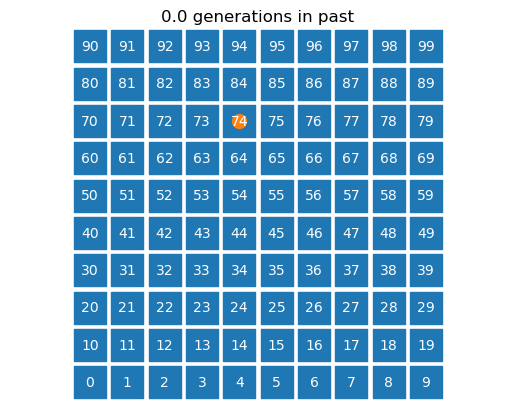

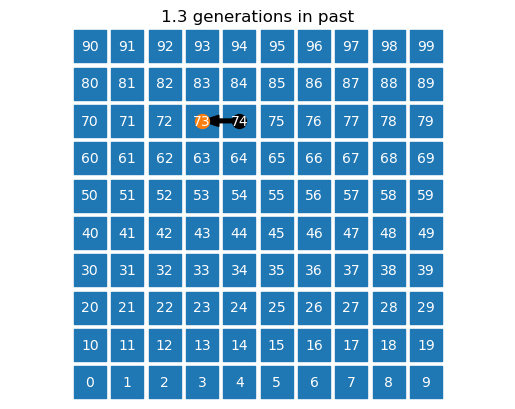

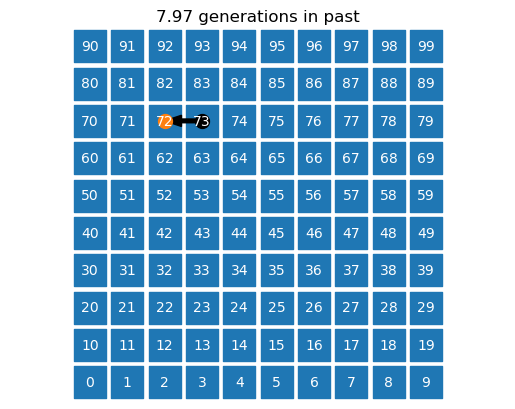

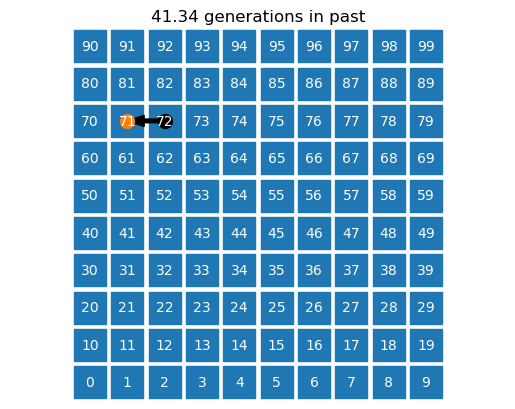

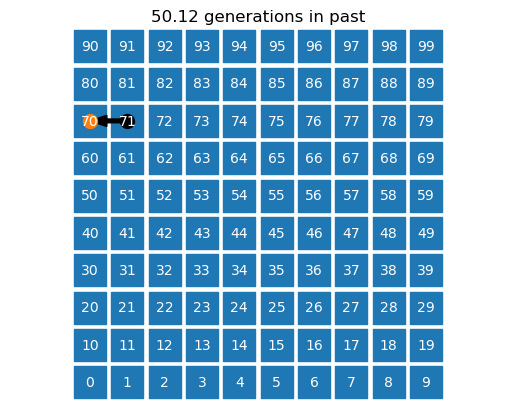

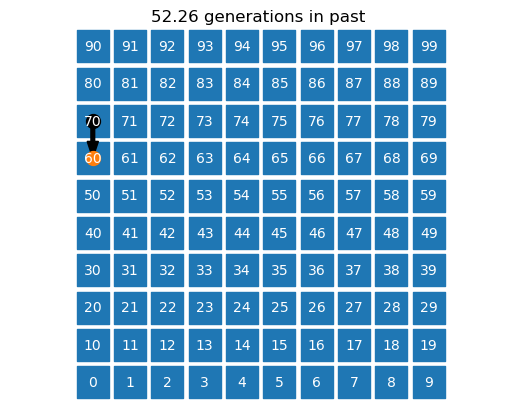

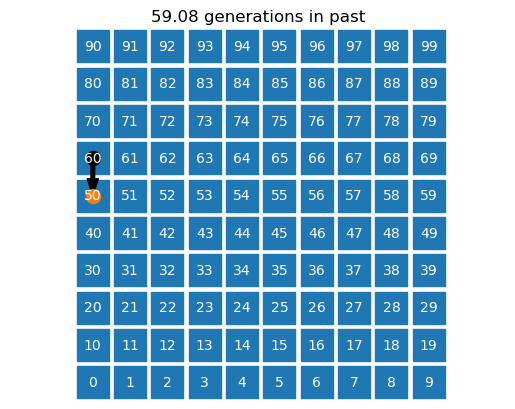

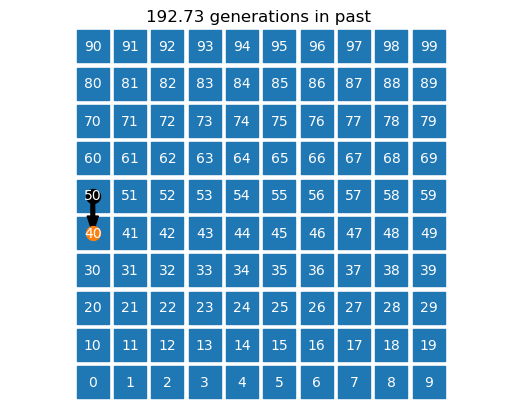

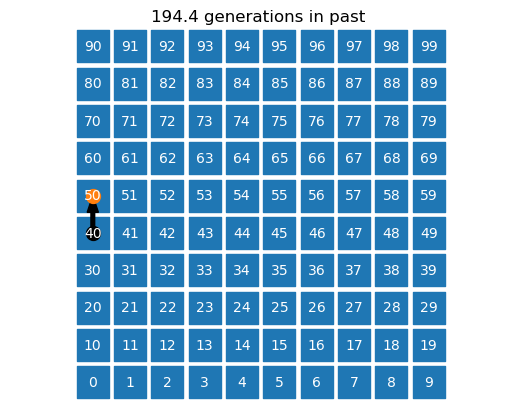

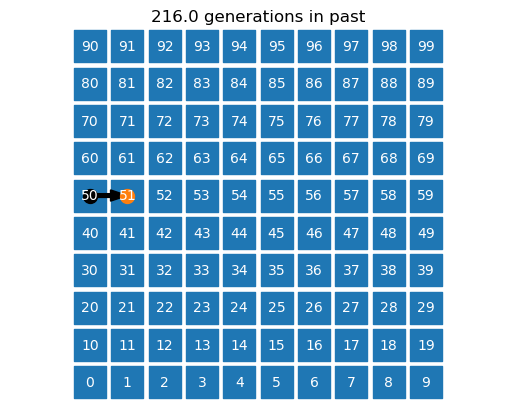

In [26]:
for t in range(10):

    fig, ax = plt.subplots()
    ax.scatter(xs, ys, marker="s", s=500)
    for i, text in enumerate(ids):
        ax.annotate(text, (xs[i], ys[i]), ha="center", va="center", color="white")
    if t > 0:
        dx = xs[positions[t]] - xs[positions[t-1]]
        dy = ys[positions[t]] - ys[positions[t-1]]
        if (dx != 0) or (dy != 0):
            ax.scatter(xs[positions[t-1]], ys[positions[t-1]], color="black", s=100)
            ax.arrow(xs[positions[t-1]], ys[positions[t-1]], dx, dy, length_includes_head=True, width=0.1, color="black")
        ax.scatter(xs[positions[t]], ys[positions[t]], s=100)
    else:
        ax.scatter(xs[positions[t]], ys[positions[t]], s=100)
    ax.axis("equal")
    ax.axis("off")
    plt.title(str(round(times[t], 2)) + " generations in past")
    plt.show()